# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation.

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import wandb

# Instantiate a rendering and a non-rendering environment.
env_render = gym.make('CartPole-v1', render_mode='human')
env = gym.make('CartPole-v1')

In [ ]:
observation, info = env.reset()
print("Observation after reset:", observation)
print("Observation space:", env.observation_space)

Observation after reset: [ 0.00178669 -0.00264036  0.02189317  0.04932993]
Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here.

In [ ]:
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action(env, obs, policy):
    dist = Categorical(policy(obs))
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1))

# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array. There's probably a better way to do this.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode(env, policy, maxlen=500):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []

    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        obs = torch.tensor(obs)
        (action, log_prob) = select_action(env, obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)

        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards)

In [ ]:
# A simple, but generic, policy network with one hidden layer.
class PolicyNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, env.action_space.n)

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.softmax(self.fc2(s), dim=-1)
        return s

In [ ]:
# A direct, inefficient, and probably buggy of the REINFORCE policy gradient algorithm.
def reinforce(policy, env, gamma=0.99, num_episodes=10, eval_interval=100, eval_episodes=10, use_standardize_baseline=True):
    # The only non-vanilla part: we use Adam instead of SGD.
    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)

    # Track episode rewards in a list.
    running_rewards = [0.0]
    eval_avg_rewards = []
    eval_avg_lengths = []
    eval_runs = 0

    # The main training loop.
    policy.train()
    for episode in range(num_episodes):
        # Run an episode of the environment, collect everything needed for policy update.
        (observations, actions, log_probs, rewards) = run_episode(env, policy)

        # Compute the discounted reward for every step of the episode.
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)

        # Keep a running average of total discounted rewards for the whole episode.
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])

        # Standardize returns if the option is enabled.
        if use_standardize_baseline:
            returns = (returns - returns.mean()) / returns.std()

        wandb.log({'episode_reward': sum(rewards)}) # Log episode reward and episode number
        # Make an optimization step
        opt.zero_grad()
        loss = (-log_probs * returns).mean()
        loss.backward()
        opt.step()

        # Perform evaluation periodically
        if (episode + 1) % eval_interval == 0:
            policy.eval()
            avg_reward = 0
            avg_length = 0
            for _ in range(eval_episodes):
                (eval_observations, eval_actions, eval_log_probs, eval_rewards) = run_episode(env, policy)
                avg_reward += sum(eval_rewards)
                avg_length += len(eval_rewards)
            avg_reward /= eval_episodes
            avg_length /= eval_episodes
            eval_avg_rewards.append(avg_reward)
            eval_avg_lengths.append(avg_length)
            wandb.log({'eval_avg_reward': avg_reward, 'eval_avg_length': avg_length}) # Log evaluation metrics and run number
            print(f'Episode {episode + 1}: Evaluation average reward: {avg_reward}')
            print(f'Episode {episode + 1}: Evaluation average length: {avg_length}')
            policy.train()

    # Return the running rewards, average evaluation rewards, and average evaluation lengths.
    policy.eval()
    return running_rewards, eval_avg_rewards, eval_avg_lengths

In [ ]:
wandb.init(project='cartpole_reinforce', config={'gamma': 0.99, 'num_episodes': 10, 'eval_interval': 100, 'eval_episodes': 10}, name="REINFORCE_No_Value_Baseline")

In [ ]:
seed = 2000
torch.manual_seed(seed)
np.random.seed(seed)

env = gym.wrappers.RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'), video_folder='./reinforce_videos', episode_trigger=lambda x: x % 100 == 0)
env.reset(seed=seed)


# Make a policy network.
policy = PolicyNet(env)

# Train the agent.
running_rewards, eval_avg_rewards, eval_avg_lengths = reinforce(policy, env, num_episodes=1000, eval_interval=100, eval_episodes=10)

# Plot the running rewards
plt.plot(running_rewards)
plt.xlabel("Episode")
plt.ylabel("Running Episode Reward")
plt.title("REINFORCE Training Progress (Running Reward)")
plt.show()

# Plot the evaluation average rewards
plt.plot(np.arange(1, len(eval_avg_rewards) + 1) * 100, eval_avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Evaluation Average Reward")
plt.title("REINFORCE Training Progress (Evaluation Reward)")
plt.show()

# Plot the evaluation average lengths
plt.plot(np.arange(1, len(eval_avg_lengths) + 1) * 100, eval_avg_lengths)
plt.xlabel("Episode")
plt.ylabel("Evaluation Average Length")
plt.title("REINFORCE Training Progress (Evaluation Length)")
plt.show()


env.close()
env_render.close()

wandb.finish()

**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

N.B for the "vanilla" cartpole enviroment the total reward and the lenght of the episode are the same

-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

In [ ]:
# Your code here. Modify your implementation of `REINFORCE` to optionally use the standardize baseline.

**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**.

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import wandb

# A simple, but generic, policy network with one hidden layer.
class PolicyNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, env.action_space.n)

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.softmax(self.fc2(s), dim=-1)
        return s

# A simple, but generic, value network with one hidden layer.
class ValueNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, 1) # Output a single value

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = self.fc2(s)
        return s

# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action(env, obs, policy):
    dist = Categorical(policy(obs))
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1))

# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array. There's probably a better way to do this.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode(env, policy, maxlen=500):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []

    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        obs = torch.tensor(obs)
        (action, log_prob) = select_action(env, obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)

        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards)


# REINFORCE policy gradient algorithm with optional value baseline.
def reinforce_with_baseline(policy, value_net, env, gamma=0.99, num_episodes=10, eval_interval=100, eval_episodes=10, use_standardize_baseline=False, lr_policy=1e-2, lr_value=2e-2, lr_scheduler_step_size=100, lr_scheduler_gamma=0.9):
    opt_policy = torch.optim.Adam(policy.parameters(), lr=lr_policy)
    opt_value = torch.optim.Adam(value_net.parameters(), lr=lr_value)
    value_criterion = nn.MSELoss()

    # Linear decay scheduler for learning rates
    scheduler_policy = torch.optim.lr_scheduler.LinearLR(opt_policy, start_factor=1.0, end_factor=0.0, total_iters=num_episodes)
    scheduler_value = torch.optim.lr_scheduler.LinearLR(opt_value, start_factor=1.0, end_factor=0.0, total_iters=num_episodes)


    running_rewards = [0.0]
    eval_avg_rewards = []
    eval_avg_lengths = []

    policy.train()
    value_net.train()
    for episode in range(num_episodes):
        (observations, actions, log_probs, rewards) = run_episode(env, policy)

        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        observations_tensor = torch.stack(observations)

        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])

        # Compute value loss and update value network
        predicted_values = value_net(observations_tensor).squeeze()
        value_loss = value_criterion(predicted_values, returns)
        opt_value.zero_grad()
        value_loss.backward()
        opt_value.step()

        # Compute advantages
        if use_standardize_baseline:
            advantages = (returns - returns.mean()) / returns.std()
        else:
            advantages = returns - predicted_values.detach()


        wandb.log({'episode_reward': sum(rewards)})
        # Make an optimization step for policy network
        opt_policy.zero_grad()
        policy_loss = (-log_probs * advantages).mean()
        policy_loss.backward()
        opt_policy.step()

        # Step the schedulers
        scheduler_policy.step()
        scheduler_value.step()


        # Perform evaluation periodically
        if (episode + 1) % eval_interval == 0:
            policy.eval()
            value_net.eval()
            avg_reward = 0
            avg_length = 0
            # Create a separate environment for evaluation to record videos
            #eval_env = gym.wrappers.RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'), video_folder=f'./reinforce_videos/episode_{episode+1}', episode_trigger=lambda x: True)

            for i in range(eval_episodes):
                (eval_observations, eval_actions, eval_log_probs, eval_rewards) = run_episode(env, policy)
                avg_reward += sum(eval_rewards)
                avg_length += len(eval_rewards)
            avg_reward /= eval_episodes
            avg_length /= eval_episodes
            eval_avg_rewards.append(avg_reward)
            eval_avg_lengths.append(avg_length)
            wandb.log({'eval_avg_reward': avg_reward, 'eval_avg_length': avg_length})
            print(f'Episode {episode + 1}: Evaluation average reward: {avg_reward}')
            print(f'Episode {episode + 1}: Evaluation average length: {avg_length}')
            # Log the videos recorded during evaluation
            #wandb.log({f"eval_video_episode_{episode+1}": wandb.Video(f'./reinforce_videos/episode_{episode+1}/rl-video-episode-0.mp4', fps=4, format="mp4")})

            #eval_env.close() # Close the evaluation environment
            policy.train()
            value_net.train()

    policy.eval()
    value_net.eval()
    return running_rewards, eval_avg_rewards, eval_avg_lengths

In [ ]:
wandb.init(project='cartpole_reinforce', config={'gamma': 0.99, 'num_episodes': 10, 'eval_interval': 100, 'eval_episodes': 10, 'policy_net_lr':1e-2, 'value_net_lr':2e-2, 'lr_scheduler_step_size':100, 'lr_scheduler_gamma':0.9}, name="REINFORCE_Value_Function_Baseline")

In [ ]:
seed = 2000
torch.manual_seed(seed)
np.random.seed(seed)

env = gym.wrappers.RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'), video_folder='./reinforce_videos', episode_trigger=lambda x: x % 100 == 0)
env.reset(seed=seed)


# Make a policy network.
policy = PolicyNet(env)
value_net = ValueNet(env)
# Train the agent.
running_rewards, eval_avg_rewards, eval_avg_lengths = reinforce_with_baseline(policy, value_net , env, num_episodes=1000, eval_interval=100, eval_episodes=10)

# Plot the running rewards
plt.plot(running_rewards)
plt.xlabel("Episode")
plt.ylabel("Running Episode Reward")
plt.title("REINFORCE Training Progress (Running Reward)")
plt.show()

# Plot the evaluation average rewards
plt.plot(np.arange(1, len(eval_avg_rewards) + 1) * 100, eval_avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Evaluation Average Reward")
plt.title("REINFORCE Training Progress (Evaluation Reward)")
plt.show()

# Plot the evaluation average lengths
plt.plot(np.arange(1, len(eval_avg_lengths) + 1) * 100, eval_avg_lengths)
plt.xlabel("Episode")
plt.ylabel("Evaluation Average Length")
plt.title("REINFORCE Training Progress (Evaluation Length)")
plt.show()


env.close()
env_render.close()

wandb.finish()

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/reinforce_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:432: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


Episode 100: Evaluation average reward: 79.0
Episode 100: Evaluation average length: 79.0
Episode 200: Evaluation average reward: 392.7
Episode 200: Evaluation average length: 392.7


KeyboardInterrupt: 

-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest)

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.



### Exercise 3.1: Solving Lunar Lander with `REINFORCE`

In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379372 sha256=9c32af11150618991fdc6d93837e2dc6396e9c676616d36b0368d5e5b05938a1
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:
# A simple, but generic, policy network with one hidden layer.
class PolicyNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, env.action_space.n)

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.softmax(self.fc2(s), dim=-1)
        return s

# A simple, but generic, value network with one hidden layer.
class ValueNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, 1) # Output a single value

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = self.fc2(s)
        return s

In [ ]:
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action_with_entropies(env, obs, policy):
    dist = Categorical(policy(obs))
    entropy = dist.entropy()
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1), entropy)

# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode_adjusted_reward(env, policy, maxlen=500):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []
    entropies = []

    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        obs = torch.tensor(obs)
        (action, log_prob, entropy) = select_action_with_entropies(env, obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        entropies.append(entropy)

        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward) # Subtract 0.1 from each reward
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards, entropies)

def beta_decay(ep, N, beta_start, beta_end):
    return beta_start - (beta_start - beta_end) * (ep / max(1, N))

In [ ]:
# REINFORCE policy gradient algorithm with optional value baseline.
def reinforce_lunar_lander(policy, value_net, env, gamma=0.99,
                           num_episodes=1000, eval_interval=100,
                           eval_episodes=10, use_standardize_baseline=False,
                           lr_policy=1e-2, lr_value=2e-2,
                           lr_start_factor_policy=1, lr_start_factor_value=1,
                           lr_end_factor_policy=0.1, lr_end_factor_value=0.5,
                           entropy_bonus_start=0.01, entropy_bonus_end=0.001):
    opt_policy = torch.optim.Adam(policy.parameters(), lr=lr_policy)
    opt_value = torch.optim.Adam(value_net.parameters(), lr=lr_value)
    value_criterion = nn.MSELoss()

    # Linear decay scheduler for learning rates
    scheduler_policy = torch.optim.lr_scheduler.LinearLR(opt_policy, start_factor=lr_start_factor_policy, end_factor=lr_end_factor_policy, total_iters=num_episodes)
    scheduler_value = torch.optim.lr_scheduler.LinearLR(opt_value, start_factor=lr_start_factor_value, end_factor=lr_end_factor_value, total_iters=num_episodes)

    running_rewards = [0.0]
    eval_avg_rewards = []
    eval_avg_lengths = []

    policy.train()
    value_net.train()
    for episode in range(num_episodes):
        (observations, actions, log_probs, rewards, entropies) = run_episode_adjusted_reward(env, policy)
        entropies = torch.stack(entropies)
        wandb.log({'episode_reward': sum(rewards)})
        #if(rewards[-1] == -100):
        #  rewards[-1]=-10
        #if(rewards[-1] < 100 and rewards[-1] > -100):
        #  rewards[-1]=-90
        #if(rewards[-1] == 100):
        #  rewards[-1] == 200
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        observations_tensor = torch.stack(observations)

        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])

        # Compute value loss and update value network
        predicted_values = value_net(observations_tensor).squeeze()
        value_loss = value_criterion(predicted_values, returns)
        opt_value.zero_grad()
        value_loss.backward()
        opt_value.step()

        # Compute advantages
        if use_standardize_baseline:
            advantages = (returns - returns.mean()) / returns.std()
        else:
            advantages = returns - predicted_values.detach()


        beta = beta_decay(episode, num_episodes, entropy_bonus_start, entropy_bonus_end)


        # Make an optimization step for policy network
        opt_policy.zero_grad()
        policy_loss = (-log_probs * advantages.detach()).mean() - beta * entropies.mean()
        policy_loss.backward()
        opt_policy.step()

        # Step the schedulers
        scheduler_policy.step()
        scheduler_value.step()


        # Perform evaluation periodically
        if (episode + 1) % eval_interval == 0:
            #print(f'Episode {episode+1} last reward: {rewards[-1]}')
            policy.eval()
            value_net.eval()
            avg_reward = 0
            avg_length = 0
            # Create a separate environment for evaluation to record videos
            eval_env = gym.wrappers.RecordVideo(gym.make('LunarLander-v3', render_mode='rgb_array'), video_folder=f'./eval_videos/episode_{episode+1}', episode_trigger=lambda x: x==1) # Record only the first episode
            eval_env.reset(seed=2000)
            for i in range(eval_episodes):
                (eval_observations, eval_actions, eval_log_probs, eval_rewards) = run_episode(eval_env, policy, maxlen=500)
                if i == 1: # Print the last reward of the first episode (the one being recorded)
                    print(f'Episode {episode + 1} recorded video last reward: {eval_rewards[-1]}')
                avg_reward += sum(eval_rewards)
                avg_length += len(eval_rewards)
            avg_reward /= eval_episodes
            avg_length /= eval_episodes
            eval_avg_rewards.append(avg_reward)
            eval_avg_lengths.append(avg_length)
            wandb.log({'eval_avg_reward': avg_reward, 'eval_avg_length': avg_length})
            print(f'Episode {episode + 1}: Evaluation average reward: {avg_reward}')
            print(f'Episode {episode + 1}: Evaluation average length: {avg_length}')
            print("--------------------------------------------------------------------")
            # Log the videos recorded during evaluation
            wandb.log({f"eval_video_episode_{episode+1}": wandb.Video(f'./eval_videos/episode_{episode+1}/rl-video-episode-1.mp4', format="mp4")})

            eval_env.close() # Close the evaluation environment
            policy.train()
            value_net.train()

    policy.eval()
    value_net.eval()
    return running_rewards, eval_avg_rewards, eval_avg_lengths

Episode 100 recorded video last reward: -100
Episode 100: Evaluation average reward: -187.1134634355962
Episode 100: Evaluation average length: 85.8
--------------------------------------------------------------------
Episode 200 recorded video last reward: -100
Episode 200: Evaluation average reward: -167.10025157625537
Episode 200: Evaluation average length: 86.5
--------------------------------------------------------------------
Episode 300 recorded video last reward: -100
Episode 300: Evaluation average reward: -179.61234096716151
Episode 300: Evaluation average length: 89.5
--------------------------------------------------------------------
Episode 400 recorded video last reward: -100
Episode 400: Evaluation average reward: -134.17423816303747
Episode 400: Evaluation average length: 119.1
--------------------------------------------------------------------
Episode 500 recorded video last reward: -100
Episode 500: Evaluation average reward: -163.96046080529172
Episode 500: Evalua

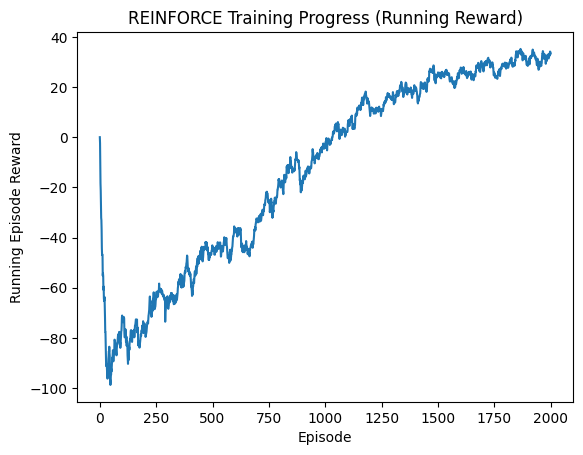

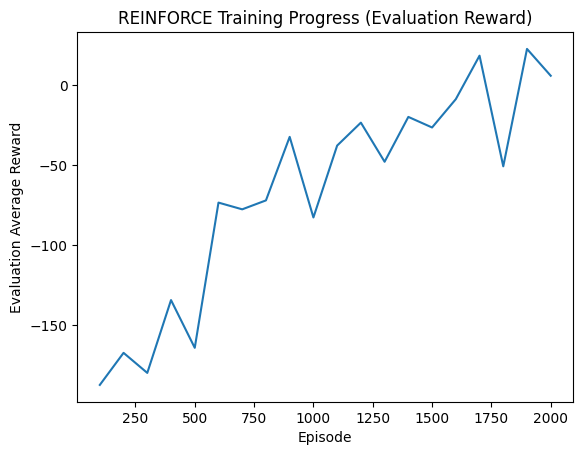

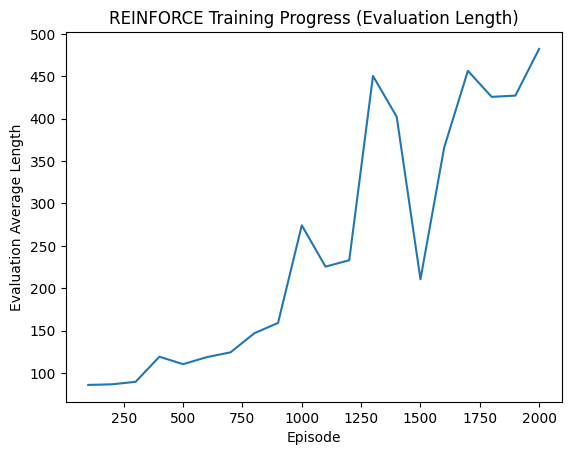

episode_reward,▄▄▅▄▄▄▅▂▆▅▁▃▂▁▄▅▅▄▅▄▄▆▇▇▆▆▆▅▃▄▆▇▇█▆▇▇▇▄█
eval_avg_length,▁▁▁▂▁▂▂▂▂▄▃▄▇▇▃▆█▇▇█
eval_avg_reward,▁▂▁▃▂▅▅▅▆▄▆▆▆▇▆▇█▆█▇
episode_reward,3.62053
eval_avg_length,482.4
eval_avg_reward,5.81172


In [ ]:
import random

# Set seeds for reproducibility
seed = 2000
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

!rm -r ./eval_videos/
!rm -r ./reinforce_videos
num_episodes=2000
lr_policy=1e-2
lr_value=2e-2
eval_interval=100
lr_start_factor_policy=1
lr_end_factor_policy=0.1
lr_start_factor_value=1
lr_end_factor_value=0.5
entropy_bonus_start=0.1
entropy_bonus_end=0.001

wandb.init(project='Lunar_Lander_reinforce',
           config={'gamma': 0.99,
                   'num_episodes': num_episodes,
                   'eval_interval': eval_interval,
                   'eval_episodes': 10,
                   'policy_net_lr':lr_policy,
                   'value_net_lr':lr_value,
                   'lr_start_factor_policy':lr_end_factor_policy,
                   'lr_end_factor_policy':lr_end_factor_policy,
                   'lr_start_factor_value':lr_start_factor_value,
                   'lr_end_factor_value':lr_end_factor_value,
                   'entropy_bonus_start':entropy_bonus_start,
                   'entopy_bonus_end':entropy_bonus_end
                   }, name="REINFORCE_linear_decay_entropy_bonus")


# Change environment to LunarLander-v2
env = gym.wrappers.RecordVideo(gym.make('LunarLander-v3', render_mode='rgb_array'), video_folder='./reinforce_videos', episode_trigger=lambda x: x % 100 == 0)
env.reset(seed=seed)


# Make a policy network.
policy = PolicyNet(env)
value_net = ValueNet(env)
# Train the agent.
running_rewards, eval_avg_rewards, eval_avg_lengths = reinforce_lunar_lander(policy, value_net ,
                                                                             env, gamma=0.99 ,
                                                                             num_episodes=num_episodes,
                                                                             eval_interval=eval_interval,
                                                                             eval_episodes=10,
                                                                             lr_policy=lr_policy ,
                                                                             lr_value=lr_value,
                                                                             lr_start_factor_policy=lr_end_factor_policy,
                                                                             lr_end_factor_policy=lr_end_factor_policy,
                                                                             lr_start_factor_value=lr_start_factor_value,
                                                                             lr_end_factor_value=lr_end_factor_value,
                                                                             entropy_bonus_start=entropy_bonus_start,
                                                                             entropy_bonus_end=entropy_bonus_end)

# Plot the running rewards
plt.plot(running_rewards)
plt.xlabel("Episode")
plt.ylabel("Running Episode Reward")
plt.title("REINFORCE Training Progress (Running Reward)")
plt.show()

# Plot the evaluation average rewards
plt.plot(np.arange(1, len(eval_avg_rewards) + 1) * 100, eval_avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Evaluation Average Reward")
plt.title("REINFORCE Training Progress (Evaluation Reward)")
plt.show()

# Plot the evaluation average lengths
plt.plot(np.arange(1, len(eval_avg_lengths) + 1) * 100, eval_avg_lengths)
plt.xlabel("Episode")
plt.ylabel("Evaluation Average Length")
plt.title("REINFORCE Training Progress (Evaluation Length)")
plt.show()


env.close()
env_render.close()

wandb.finish()

# Task
Implement batching for the REINFORCE algorithm applied to the Lunar Lander environment to reduce training noise.

## Modify `run episode`

### Subtask:
Update the `run_episode` function to return the collected data as a list of dictionaries, where each dictionary contains the observations, actions, log probabilities, and rewards for a single episode.


**Reasoning**:
The subtask is to modify the `run_episode_adjusted_reward` function to return a dictionary. I will update the function definition and the return statement to achieve this.



In [ ]:
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action_with_entropies(env, obs, policy):
    dist = Categorical(policy(obs))
    entropy = dist.entropy()
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1), entropy)

prova a forzare l'azione di stafre fermo dopo 400 step!!

In [ ]:
# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode_adjusted_reward(env, policy, maxlen=500):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []
    entropies = []

    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        obs = torch.tensor(obs)
        (action, log_prob, entropy) = select_action_with_entropies(env, obs, policy)

        # Force action 0 (no engines) after 400 steps
        if i >= 400:
            action = 0
            # We need to recompute the log_prob for the forced action to ensure the policy gradient is correct
            # when we use this episode for training.
            dist = Categorical(policy(obs))
            log_prob = dist.log_prob(torch.tensor(action)).reshape(1)


        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        entropies.append(entropy)

        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    #if(rewards[-1] == -100):
      #  rewards[-1]=-10
    #if(rewards[-1] < 100 and rewards[-1] > -100):
        #rewards[-1]=-50
    #if(rewards[-1] == 100):
      #  rewards[-1] == 200
    return {
        'observations': observations,
        'actions': actions,
        'log_probs': torch.cat(log_probs),
        'rewards': rewards,
        'entropies': torch.stack(entropies)
    }

## Compute and apply gradients

### Subtask:
Calculate the policy and value losses based on the batched data and perform a single optimization step for both networks.


**Reasoning**:
Calculate the policy and value losses based on the batched data and perform a single optimization step for both networks.



In [ ]:
# REINFORCE policy gradient algorithm with optional value baseline.
def reinforce_lunar_lander(policy, value_net, env, gamma=0.99,
                           num_epochs=1000, eval_interval_epochs=10, # Changed to num_epochs and eval_interval_epochs
                           eval_episodes=10, use_standardize_baseline=False,
                           lr_policy=1e-2, lr_value=2e-2,
                           lr_start_factor_policy=1, lr_start_factor_value=1,
                           lr_end_factor_policy=0.1, lr_end_factor_value=0.5,
                           entropy_bonus_start=0.01, entropy_bonus_end=0.001,
                           batch_size=1):
    opt_policy = torch.optim.Adam(policy.parameters(), lr=lr_policy, betas=(0.9, 0.999), eps=1e-5)
    opt_value = torch.optim.AdamW(value_net.parameters(), lr=lr_value, betas=(0.9, 0.999), eps=1e-5, weight_decay=1e-4)
    value_criterion = nn.MSELoss()

    # Linear decay scheduler for learning rates
    # Schedulers will now step once per epoch
    scheduler_policy = torch.optim.lr_scheduler.LinearLR(opt_policy, start_factor=lr_start_factor_policy, end_factor=lr_end_factor_policy, total_iters=num_epochs)
    scheduler_value = torch.optim.lr_scheduler.LinearLR(opt_value, start_factor=lr_start_factor_value, end_factor=lr_end_factor_value, total_iters=num_epochs)


    running_rewards = [0.0]
    eval_avg_rewards = []
    eval_avg_lengths = []

    policy.train()
    value_net.train()
    best_eval_reward = -float('inf') # Initialize best evaluation reward
    global_step = 0 # Track total steps for logging
    for epoch in range(num_epochs): # Iterate for num_epochs
        batch_data = []
        batch_rewards = []
        for _ in range(batch_size):
            episode_data = run_episode_adjusted_reward(env, policy)
            batch_data.append(episode_data)
            batch_rewards.append(sum(episode_data['rewards']))
            # Log the reward for each individual episode collected within the batch
            wandb.log({'episode_reward': sum(episode_data['rewards'])}, step=global_step)
            global_step += 1

        # Concatenate data from the batch
        all_log_probs = torch.cat([d['log_probs'] for d in batch_data])
        all_rewards = [r for d in batch_data for r in d['rewards']]
        all_observations = torch.cat([torch.stack(d['observations']) for d in batch_data])

        # Compute discounted returns for each episode in the batch and concatenate
        all_returns = torch.cat([torch.tensor(compute_returns(d['rewards'], gamma), dtype=torch.float32) for d in batch_data])
        all_entropies = torch.cat([d['entropies'] for d in batch_data])

        # Keep a running average of total discounted rewards for the whole episode.
        # This running average is now across the last episode of each batch.
        running_rewards.append(0.05 * all_returns[0].item() + 0.95 * running_rewards[-1])


        # Compute value loss and update value network
        predicted_values = value_net(all_observations).squeeze()
        value_loss = value_criterion(predicted_values, all_returns)
        opt_value.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(value_net.parameters(), 1.0)
        opt_value.step()

        # Compute advantages
        if use_standardize_baseline:
            advantages = (all_returns - all_returns.mean()) / all_returns.std()
        else:
            advantages = all_returns - predicted_values.detach()

        beta = beta_decay(epoch, num_epochs, entropy_bonus_start, entropy_bonus_end) # Decay beta based on epoch


        # Make an optimization step for policy network
        opt_policy.zero_grad()
        policy_loss = (-all_log_probs * advantages.detach()).mean() - beta * all_entropies.mean()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), 0.5)
        opt_policy.step()

        # Step the schedulers
        scheduler_policy.step()
        scheduler_value.step()

        # Perform evaluation periodically
        if (epoch + 1) % eval_interval_epochs == 0: # Evaluate based on epochs
            policy.eval()
            value_net.eval()
            avg_reward = 0
            avg_length = 0
            eval_env = gym.wrappers.RecordVideo(gym.make('LunarLander-v3', render_mode='rgb_array'), video_folder=f'./eval_videos/episode_{(epoch+1)*batch_size}', episode_trigger=lambda x: x==1) # Use episode count for video folder name
            eval_env.reset(seed=2000)
            for i in range(eval_episodes):
                (eval_observations, eval_actions, eval_log_probs, eval_rewards) = run_episode(eval_env, policy, maxlen=500)
                if i == 1:
                    print(f'Episode {(epoch+1)*batch_size} recorded video last reward: {eval_rewards[-1]}')
                avg_reward += sum(eval_rewards)
                avg_length += len(eval_rewards)
            avg_reward /= eval_episodes
            avg_length /= eval_episodes
            eval_avg_rewards.append(avg_reward)
            eval_avg_lengths.append(avg_length)
            wandb.log({'eval_avg_reward': avg_reward, 'eval_avg_length': avg_length}, step=global_step) # Log evaluation metrics at the global step count
            print(f'Episode {(epoch+1)*batch_size}: Evaluation average reward: {avg_reward}')
            print(f'Episode {(epoch+1)*batch_size}: Evaluation average length: {avg_length}')
            print("--------------------------------------------------------------------")
            wandb.log({f"eval_video_episode_{(epoch+1)*batch_size}": wandb.Video(f'./eval_videos/episode_{(epoch+1)*batch_size}/rl-video-episode-1.mp4', format="mp4")}, step=global_step)

            # Checkpoint the model if the current average evaluation reward is the best and above 200
            if avg_reward > best_eval_reward and avg_reward >= 200:
                best_eval_reward = avg_reward
                print(f"New best evaluation reward of {best_eval_reward} achieved at epoch {epoch+1}. Saving model checkpoint.")
                torch.save({
                    'epoch': epoch + 1,
                    'policy_state_dict': policy.state_dict(),
                    'value_net_state_dict': value_net.state_dict(),
                    'optimizer_policy_state_dict': opt_policy.state_dict(),
                    'optimizer_value_state_dict': opt_value.state_dict(),
                    'best_eval_reward': best_eval_reward
                }, f'./reinforce_lunar_lander_best_model_epoch_{(epoch+1)*batch_size}.pth')
                wandb.save(f'./reinforce_lunar_lander_best_model_epoch_{(epoch+1)*batch_size}.pth')
                artifact = wandb.Artifact(
                    name="modello-lunar-lander",
                    type="model",
                    description="Stato allenamento su LunarLander",
                    metadata={"epoch": epoch, "best_eval_reward": best_eval_reward}
                    )
                artifact.add_file(f'./reinforce_lunar_lander_best_model_epoch_{(epoch+1)*batch_size}.pth')
                wandb.log_artifact(artifact)

            eval_env.close()
            policy.train()
            value_net.train()

    policy.eval()
    value_net.eval()
    return running_rewards, eval_avg_rewards, eval_avg_lengths

In [ ]:
import random

# Set seeds for reproducibility
seed = 2000
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

!rm -r ./eval_videos/
!rm -r ./reinforce_videos
num_epochs=2000
lr_policy=1e-2
lr_value=2e-2
eval_interval=20
lr_start_factor_policy=1
lr_end_factor_policy=0.1
lr_start_factor_value=1
lr_end_factor_value=0.5
entropy_bonus_start=0
entropy_bonus_end=0
batch_size = 5 # Set the batch size

wandb.init(project='Lunar_Lander_reinforce',
           config={'gamma': 0.99,
                   'num_epochs': num_epochs,
                   'eval_interval': eval_interval,
                   'eval_episodes': 10,
                   'policy_net_lr':lr_policy,
                   'value_net_lr':lr_value,
                   'lr_start_factor_policy':lr_end_factor_policy,
                   'lr_end_factor_policy':lr_end_factor_policy,
                   'lr_start_factor_value':lr_start_factor_value,
                   'lr_end_factor_value':lr_end_factor_value,
                   'entropy_bonus_start':entropy_bonus_start,
                   'entopy_bonus_end':entropy_bonus_end,
                   'batch_size': batch_size  # Log batch size
                   }, name=f"REINFORCE_linear_decay_entropy_bonus_batch_{batch_size}")


# Change environment to LunarLander-v2
env = gym.wrappers.RecordVideo(gym.make('LunarLander-v3', render_mode='rgb_array'), video_folder='./reinforce_videos', episode_trigger=lambda x: x % 100 == 0)
env.reset(seed=seed)


# Make a policy network.
policy = PolicyNet(env)
value_net = ValueNet(env)
# Train the agent.
running_rewards, eval_avg_rewards, eval_avg_lengths = reinforce_lunar_lander(policy, value_net ,
                                                                             env, gamma=0.99 ,
                                                                             num_epochs=num_epochs,
                                                                             eval_interval_epochs=eval_interval,
                                                                             eval_episodes=10,
                                                                             lr_policy=lr_policy ,
                                                                             lr_value=lr_value,
                                                                             lr_start_factor_policy=lr_end_factor_policy,
                                                                             lr_end_factor_policy=lr_end_factor_policy,
                                                                             lr_start_factor_value=lr_start_factor_value,
                                                                             lr_end_factor_value=lr_end_factor_value,
                                                                             entropy_bonus_start=entropy_bonus_start,
                                                                             entropy_bonus_end=entropy_bonus_end,
                                                                             batch_size=batch_size) # Pass batch_size


env.close()
# env_render.close() # env_render was closed in the previous run

wandb.finish()

Episode 100 recorded video last reward: -100
Episode 100: Evaluation average reward: -188.9065922629954
Episode 100: Evaluation average length: 80.2
--------------------------------------------------------------------
Episode 200 recorded video last reward: -100
Episode 200: Evaluation average reward: -155.45576593856683
Episode 200: Evaluation average length: 87.3
--------------------------------------------------------------------
Episode 300 recorded video last reward: -100
Episode 300: Evaluation average reward: -147.11371362018366
Episode 300: Evaluation average length: 86.6
--------------------------------------------------------------------
Episode 400 recorded video last reward: -100
Episode 400: Evaluation average reward: -147.9301162550398
Episode 400: Evaluation average length: 100.0
--------------------------------------------------------------------
Episode 500 recorded video last reward: -100
Episode 500: Evaluation average reward: -132.74117601746948
Episode 500: Evaluat

episode_reward,▂▃▃▂▁▄▄▄▄▅▄▇▇▆▇█▆▇▇▁▄▇▇▃▇▇█▇████▇▇██▅▇█▇
eval_avg_length,▁▁▂▂▁▃▅█▅▇▇█▇▄▇▄█▆▄▅▆▆▅▅▃▅▆▅▆▆▇▆▅▄▄▅▄▆▅▅
eval_avg_reward,▂▂▂▂▁▂▂▂▄▄▃▃▅▆▆▅▆▇▇▆▅▆▇▆▇▆▆▇█▆▅▆▇▇▇▇▇███
episode_reward,245.62775
eval_avg_length,251.1
eval_avg_reward,248.57707


In [ ]:
# Load the best saved model
best_model_path = './reinforce_lunar_lander_best_model_epoch_5.pth' # Update this path to your best model file

checkpoint = torch.load(best_model_path, weights_only=False)
loaded_policy = PolicyNet(gym.make('LunarLander-v3'))
loaded_policy.eval()

test_env = gym.make('LunarLander-v3', render_mode='rgb_array')

# Run 20 test episodes
num_test_episodes = 20
test_rewards = []
test_lengths = []

print(f"Running {num_test_episodes} test episodes with the best saved model...")

for i in range(num_test_episodes):
    (observations, actions, log_probs, rewards) = run_episode(test_env, loaded_policy, maxlen=500)
    test_rewards.append(sum(rewards))
    test_lengths.append(len(rewards))
    print(f"Test Episode {i+1}: Reward = {sum(rewards)}, Length = {len(rewards)}")

# Calculate and print average test results
avg_test_reward = np.mean(test_rewards)
avg_test_length = np.mean(test_lengths)

print("\n--- Test Results ---")
print(f"Average Test Reward: {avg_test_reward}")
print(f"Average Test Length: {avg_test_length}")

test_env.close()

Running 20 test episodes with the best saved model...
Test Episode 1: Reward = -160.36644764427055, Length = 86
Test Episode 2: Reward = -172.53880713806907, Length = 79
Test Episode 3: Reward = -100.07932903831667, Length = 79
Test Episode 4: Reward = -141.645167865293, Length = 86
Test Episode 5: Reward = -124.20016734402346, Length = 56
Test Episode 6: Reward = -460.16853923043186, Length = 123
Test Episode 7: Reward = -133.1947238196009, Length = 92
Test Episode 8: Reward = -138.77180148292788, Length = 79
Test Episode 9: Reward = -391.07213867079025, Length = 94
Test Episode 10: Reward = -113.56676856568585, Length = 80
Test Episode 11: Reward = -99.11985209871285, Length = 83
Test Episode 12: Reward = -264.81884785680427, Length = 100
Test Episode 13: Reward = -112.6778686571159, Length = 62
Test Episode 14: Reward = -195.51990267681396, Length = 68
Test Episode 15: Reward = -173.16780655270804, Length = 86
Test Episode 16: Reward = -333.3178729625042, Length = 88
Test Episode 17